# Presentation Plots

## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
import math
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import sklearn.mixture as mix
import datetime as dt

import mypack.plot as plot
import mypack.calc as calc
import mypack.clas as clas
import mypack.data as data

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set() # sets matplotlib style
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Import data

In [6]:
#df_market = pd.read_pickle('df_ts_estimates.pkl')

In [6]:
df_daily = data.download_factor_data('D')['Mkt-RF']/100
df_monthly = data.download_factor_data('M')['Mkt-RF']/100

## Kernel vs. Normal Plots

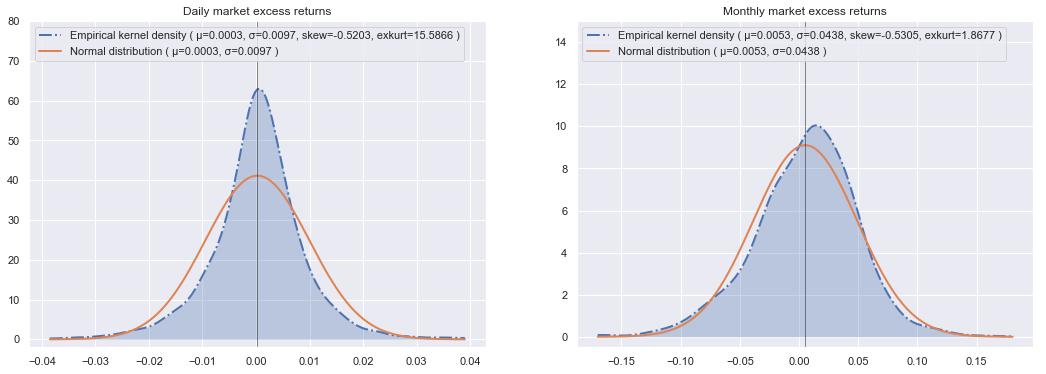

In [208]:
#plot
fig,axes = plt.subplots(1,2,figsize=[18,6])

datasets = [df_daily,df_monthly]
titles = ['Kernel density estimate and fitted normal distribution of daily market excess return data',
         'Kernel density estimate and fitted normal distribution of monthly market excess return data']
titles = ['Daily market excess returns',
         'Monthly market excess returns']
ylims = [[-2,80],[-0.5,15]]
#ax.axhline(0, color='k', linewidth=0.5)

for ax,y,tit,lim in zip(axes,datasets,titles,ylims):
    # data
    y = y[y.index > dt.datetime(1960,1,1)]

    # create kernel density estimate
    kerneldensity  = sp.stats.gaussian_kde(y)
    (m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
    kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
    
    # create normal
    x = np.linspace(m-4*v**0.5, m+4*v**0.5, 201)
    y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
    normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'
    
    # plot densities
    ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
    ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
    ax.plot(x, y_normal, label=normal_label, linestyle='-', linewidth=2)
    
    ax.axvline(m, color='k', linewidth=0.5)
    ax.legend(loc='upper left')
    ax.set_title(tit)
    ax.set_ylim(lim)
    
plt.show()

fig.savefig('kernelVsNormalPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Hidden Markov Model
### Daily

In [210]:
# data
y = df_daily[df_daily.index > dt.datetime(1960,1,1)]

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [211]:
# estimate mixture (from Hidden Markov Model)
hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=[0.95,0.02,m,m,v*2,v/2], method='powell', disp=False)
(mu_0, mu_1) = hmm_model.params.values[2:4]
(sigma_0, sigma_1) = hmm_model.params.values[4:6]**0.5
(p0, p1) = hmm_model.smoothed_marginal_probabilities.mean().values
mixture_hmm = clas.MixtureDistribution([(mu_0, sigma_0, p0),(mu_1, sigma_1, p1)])

(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [212]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_hmm.components]
sigmas += [s for (m,s,p) in mixture_hmm.components]
ps += [p for (m,s,p) in mixture_hmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_hmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [213]:
# labels
(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

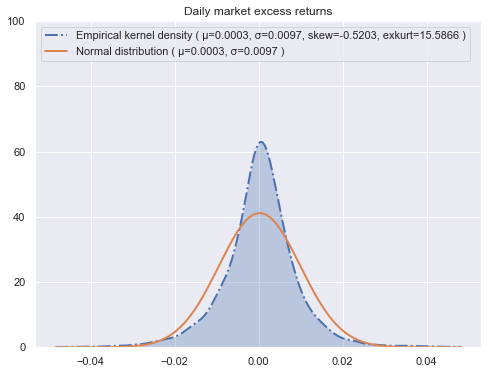

In [215]:
#plot
fig,ax = plt.subplots(1,1,figsize=[8,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='-', linewidth=2)
#ax.plot(x, y_mix, label=mix_label, linewidth=2, linestyle='--')

#for iComp in range(0,len(ys)):
#    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Daily market excess returns')
ax.set_ylim([0,100])
plt.show()

fig.savefig('DailyDensityPlot1.pdf', format='pdf', dpi=200, bbox_inches='tight')

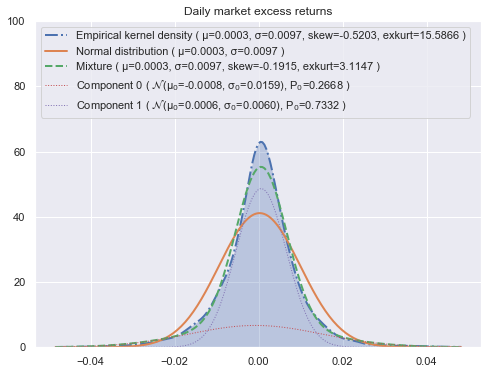

In [216]:
#plot
fig,ax = plt.subplots(1,1,figsize=[8,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='-', linewidth=2)
ax.plot(x, y_mix, label=mix_label, linewidth=2, linestyle='--')

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Daily market excess returns')
ax.set_ylim([0,100])
plt.show()

fig.savefig('DailyDensityPlot2.pdf', format='pdf', dpi=200, bbox_inches='tight')

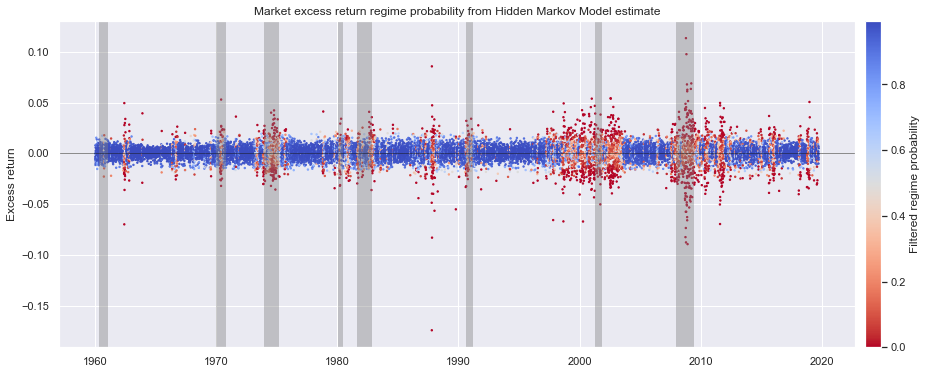

In [165]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1]
size = 2#(color+5)
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Filtered regime probability')
plt.show()

#fig.savefig('hiddenMarkovModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

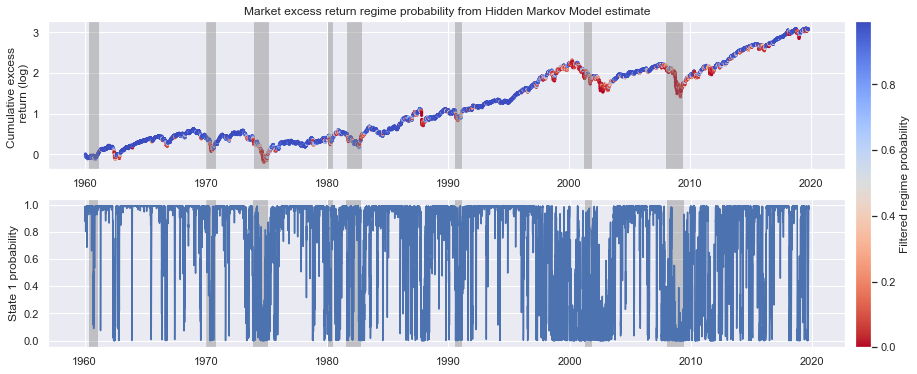

In [235]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, axes = plt.subplots(2,1,figsize=[17,6])
ax = axes[0]
plot.add_recession_bars(ax, startdate=y.index[0])
#ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1]#.shift(1)
size = 5#(color+5)

scat = ax.scatter(y.index, np.log(1+y).cumsum(), c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Cumulative excess \n return (log)')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01, ax=axes)
cbar.set_label('Filtered regime probability')

ax = axes[1]
#ax.plot(hmm_model.smoothed_marginal_probabilities[1])#, alpha=0.8, color='green')
#scat = ax.scatter(y.index, hmm_model.filtered_marginal_probabilities[1], c=color, cmap=colormap, s=size, rasterized=True, zorder=2)
ax.plot(hmm_model.filtered_marginal_probabilities[1],  zorder=1)#, alpha=0.8, color='green')
ax.set_ylabel('State 1 probability')
plot.add_recession_bars(ax, startdate=y.index[0])

plt.show()

fig.savefig('dailyStateProbabilities.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [72]:
p00 = hmm_model.params.values[0]
p10 = hmm_model.params.values[1]
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]
mc = clas.MarkovChain(transition_matrix)
steady_state = mc.calculate_steady_state()
expected_durations = mc.calculate_expected_durations()
#steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

hmm_parameter_table = pd.DataFrame(index=['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$','$\sigma_0$','$\sigma_1$','$P_{SS}[S=0]$','$P_{SS}[S=1]$','Exp. duration state 0','Exp. duration state 1'],columns=['estimate','s.e.'])

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'estimate'] = hmm_model.params.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'estimate'] = hmm_model.params.values[4:6]**0.5

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'s.e.'] = hmm_model.bse.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'s.e.'] = hmm_model.bse.values[4:6]**0.5

hmm_parameter_table.loc[['$P_{SS}[S=0]$','$P_{SS}[S=1]$'],'estimate'] = steady_state
hmm_parameter_table.loc[['Exp. duration state 0','Exp. duration state 1'],'estimate'] = expected_durations

hmm_parameter_table[hmm_parameter_table.isna()] = ''
hmm_parameter_table

#calc.export_df_to_latex(hmm_parameter_table, 'hmm_parameter_table')

,estimate,s.e.
$p_{00}$,0.9655,0.0055
$p_{10}$,0.0124,0.0018
$\mu_0$,-0.0008,0.0003
$\mu_1$,0.0006,0.0001
$\sigma_0$,0.0159,0.0044
$\sigma_1$,0.0060,0.0011
$P_{SS}[S=0]$,0.2647,
$P_{SS}[S=1]$,0.7353,
Exp. duration state 0,28.9799,
Exp. duration state 1,80.5193,


### Monthly

In [238]:
# data
y = df_monthly[df_monthly.index > dt.datetime(1960,1,1)]

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [239]:
# estimate mixture (from Hidden Markov Model)
hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=[0.95,0.02,m,m,v*2,v/2], method='powell', disp=False)
(mu_0, mu_1) = hmm_model.params.values[2:4]
(sigma_0, sigma_1) = hmm_model.params.values[4:6]**0.5
(p0, p1) = hmm_model.smoothed_marginal_probabilities.mean().values
mixture_hmm = clas.MixtureDistribution([(mu_0, sigma_0, p0),(mu_1, sigma_1, p1)])

(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

In [240]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_hmm.components]
sigmas += [s for (m,s,p) in mixture_hmm.components]
ps += [p for (m,s,p) in mixture_hmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_hmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [241]:
# labels
(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

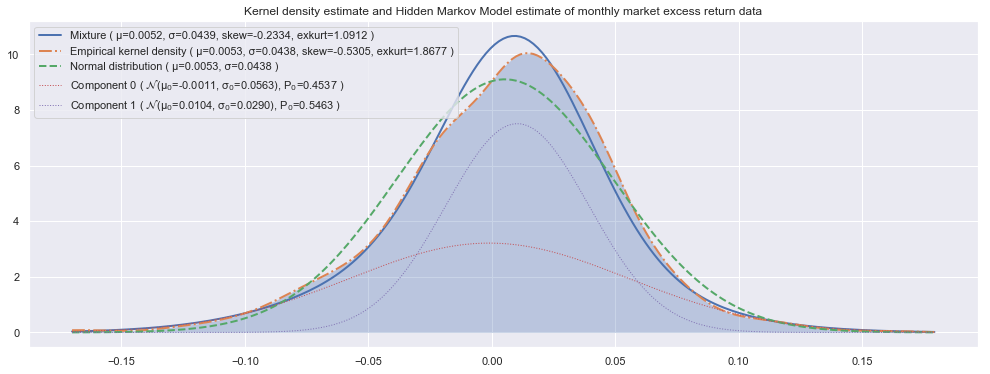

In [242]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='--', linewidth=2)

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Kernel density estimate and Hidden Markov Model estimate of monthly market excess return data')
plt.show()

#fig.savefig('hiddenMarkovModelDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

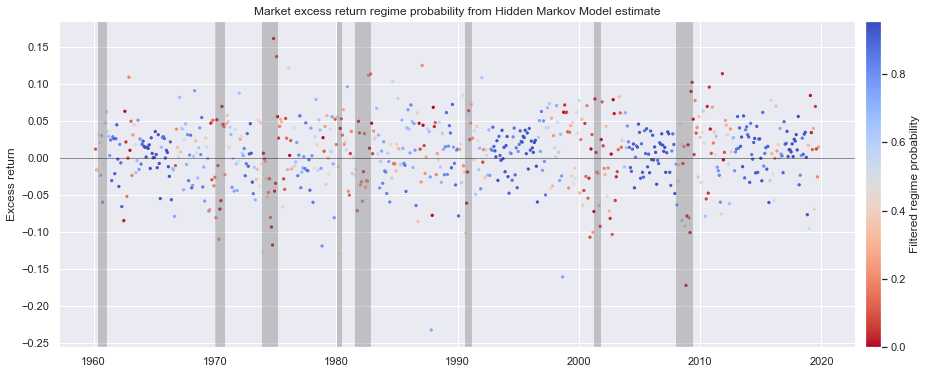

In [243]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1].shift(1)
size = 5#(color+5)
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Filtered regime probability')
plt.show()

#fig.savefig('hiddenMarkovModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

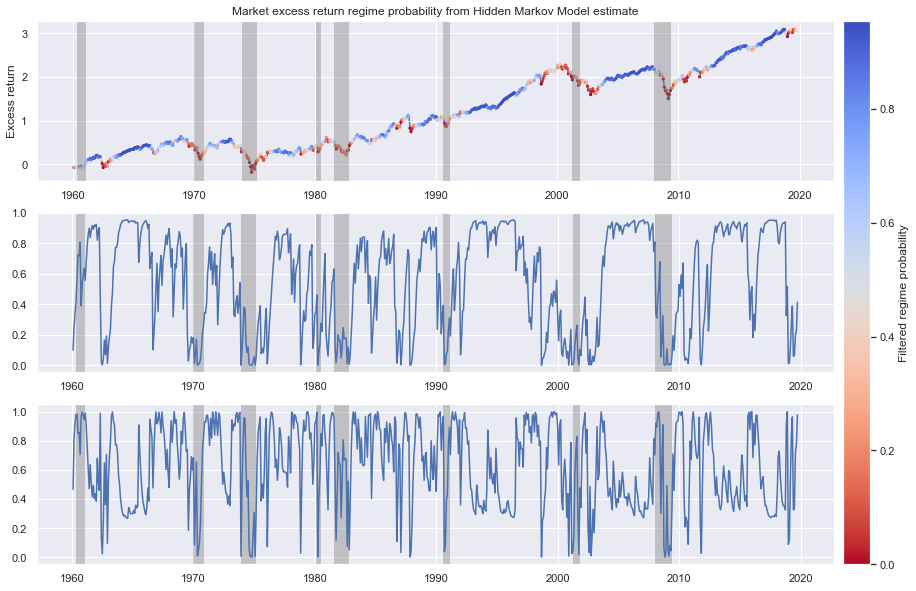

In [244]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, axes = plt.subplots(3,1,figsize=[17,10])
ax = axes[0]
plot.add_recession_bars(ax, startdate=y.index[0])
#ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1]#.shift(1)
size = 5#(color+5)

ax.plot(y.index, np.log(1+y).cumsum(), rasterized=True, zorder=0)
scat = ax.scatter(y.index, np.log(1+y).cumsum(), c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01, ax=axes)
cbar.set_label('Filtered regime probability')

ax = axes[1]
#ax.plot(hmm_model.smoothed_marginal_probabilities[1])#, alpha=0.8, color='green')
ax.plot(hmm_model.filtered_marginal_probabilities[1])#, alpha=0.8, color='green')
plot.add_recession_bars(ax, startdate=y.index[0])

ax = axes[2]
#ax.plot(hmm_model.smoothed_marginal_probabilities[1])#, alpha=0.8, color='green')
w = hmm_model.filtered_marginal_probabilities[1]
ent = -w*np.log(w)/np.log(2) - (1-w)*np.log(1-w)/np.log(2)
ax.plot(ent)#, alpha=0.8, color='green')
plot.add_recession_bars(ax, startdate=y.index[0])

plt.show()

#fig.savefig('hiddenMarkovModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

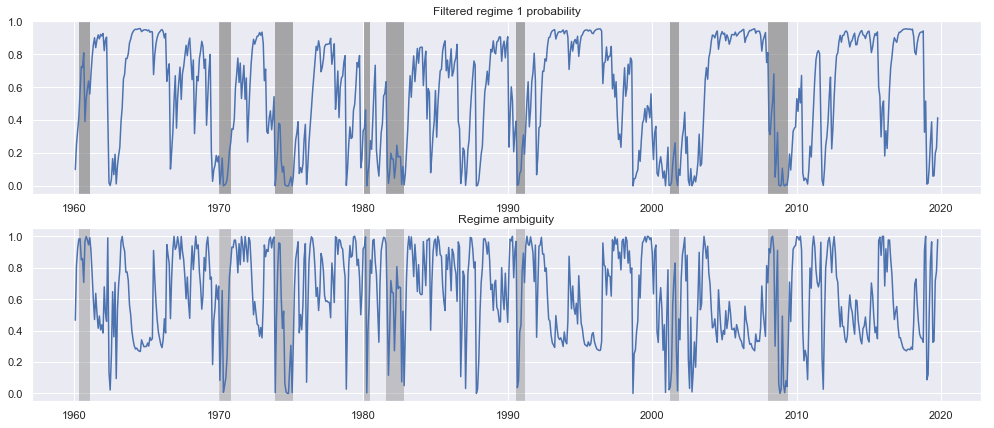

In [247]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, axes = plt.subplots(2,1,figsize=[17,7])
ax = axes[0]
plot.add_recession_bars(ax, startdate=y.index[0])
#ax.plot(hmm_model.smoothed_marginal_probabilities[1])#, alpha=0.8, color='green')
ax.plot(hmm_model.filtered_marginal_probabilities[1])#, alpha=0.8, color='green')
plot.add_recession_bars(ax, startdate=y.index[0])
ax.set_title('Filtered regime 1 probability')

ax = axes[1]
#ax.plot(hmm_model.smoothed_marginal_probabilities[1])#, alpha=0.8, color='green')
w = hmm_model.filtered_marginal_probabilities[1]
ent = -w*np.log(w)/np.log(2) - (1-w)*np.log(1-w)/np.log(2)
ax.plot(ent)#, alpha=0.8, color='green')
plot.add_recession_bars(ax, startdate=y.index[0])
ax.set_title('Regime ambiguity')

plt.show()

fig.savefig('ambiguityTimeSeriesMonthly.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [62]:
p00 = hmm_model.params.values[0]
p10 = hmm_model.params.values[1]
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]
mc = clas.MarkovChain(transition_matrix)
steady_state = mc.calculate_steady_state()
expected_durations = mc.calculate_expected_durations()
#steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

hmm_parameter_table = pd.DataFrame(index=['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$','$\sigma_0$','$\sigma_1$','$P_{SS}[S=0]$','$P_{SS}[S=1]$','Exp. duration state 0','Exp. duration state 1'],columns=['estimate','s.e.'])

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'estimate'] = hmm_model.params.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'estimate'] = hmm_model.params.values[4:6]**0.5

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'s.e.'] = hmm_model.bse.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'s.e.'] = hmm_model.bse.values[4:6]**0.5

hmm_parameter_table.loc[['$P_{SS}[S=0]$','$P_{SS}[S=1]$'],'estimate'] = steady_state
hmm_parameter_table.loc[['Exp. duration state 0','Exp. duration state 1'],'estimate'] = expected_durations

hmm_parameter_table[hmm_parameter_table.isna()] = ''
hmm_parameter_table

#calc.export_df_to_latex(hmm_parameter_table, 'hmm_parameter_table')

,estimate,s.e.
$p_{00}$,0.9453,0.0568
$p_{10}$,0.0450,0.0198
$\mu_0$,-0.0011,0.0086
$\mu_1$,0.0104,0.0024
$\sigma_0$,0.0563,0.0312
$\sigma_1$,0.0290,0.0178
$P_{SS}[S=0]$,0.4512,
$P_{SS}[S=1]$,0.5488,
Exp. duration state 0,18.2745,
Exp. duration state 1,22.2295,


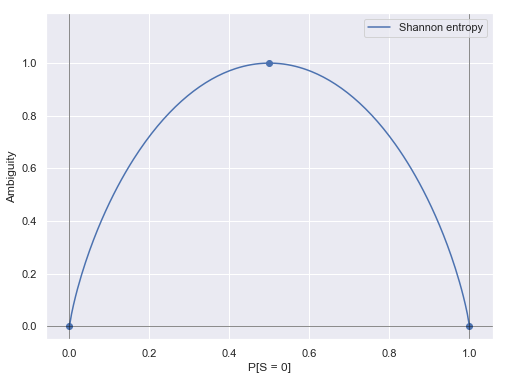

In [251]:
x = np.linspace(0.0001,0.9999,201)
y1 = calc.calculate_binary_entropy(x)
y2 = 1-4*(0.5-x)**2
y3 = 2*np.minimum(x,1-x)

fig, ax = plt.subplots(1,1, figsize=[8,6])

ax.plot(x,y1, label = 'Shannon entropy')
#ax.plot(x,y2, label = 'Euclidean distance', linestyle='--')
#ax.plot(x,y3, label = 'Minimum', linestyle='-.')
ax.scatter([0,0.5,1],[0,1,0])
ax.set_ylim([-0.05,1.19])
ax.axhline(0, linewidth=0.5, color='k')
ax.axvline(0, linewidth=0.5, color='k')
ax.axvline(1, linewidth=0.5, color='k')
ax.set_xlabel('P[S = 0]')
ax.set_ylabel('Ambiguity')
ax.legend(loc='upper right')

plt.show()

#fig.savefig('ambiguityFunctionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')